In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys
print(sys.executable)

/opt/ml/miniconda3/envs/clf/bin/python


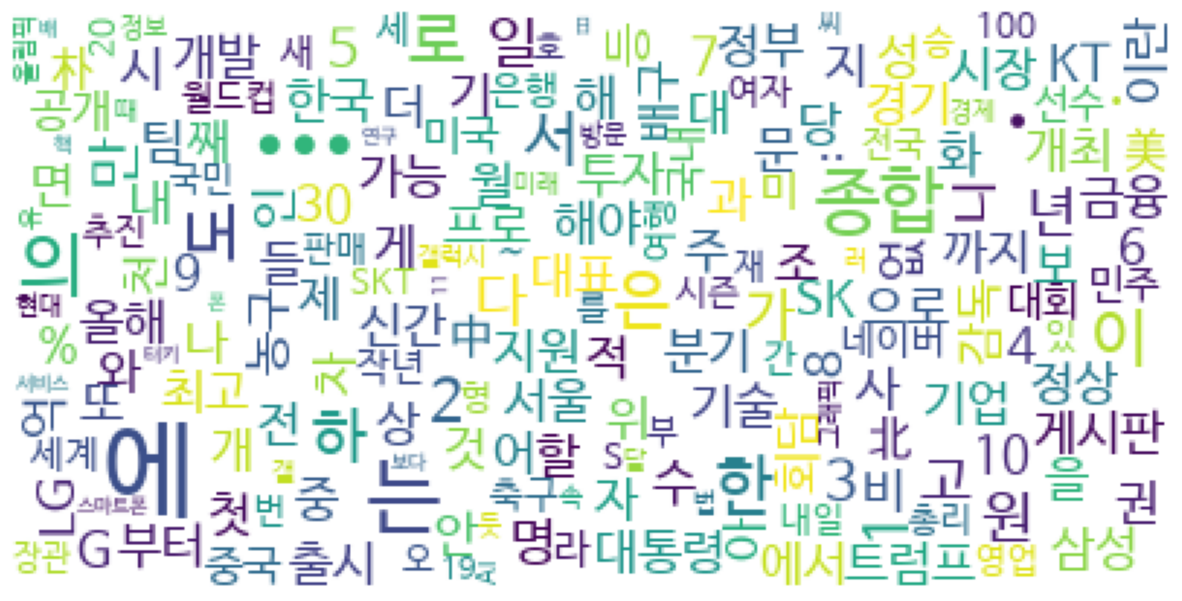

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

* 영어, 한자, 특수 기호 처리
* 형태소에 따른 처리도 필요

In [5]:
CHN_KOR_DICT = {
    "外人":"외국인", "日":"일본", "美":"미국", "北":"북한", "英":"영국", "中":"중국", "與":"여당", "靑":"청와대", "野":"야당", "伊":"이탈리아", "韓":"한국", "南":"한국", "獨":"독일", 
    "佛":"프랑스", "檢":"검찰", "銀":"은행", "亞":"아시아", "人":"사람", "孫":"손혜원", "企":"기업", "前":"이전", "反":"반대", "安":"안철수", "展":"전시회", "故":"사망", "文":"문재인", 
    "新":"새로운", "曺":"조국", "朴":"박근혜", "株":"주식", "男":"남자", "硏":"연구", "車":"자동차", "軍":"군대", "重":"중공업"
}

SPECIAL_WORD_DICT ={'↑':'상승', '↓':'하락', '러':'러시아', 'ℓ':'리터', '→':'에서 ', '…':' ', 
                    '·':' 및 ', '㈜':'', 'B52':''}

ENG_KOR_DICT = {
    'NYT':'미국 일간지','WP':'미국 일간지', 'KAIST':'카이스트', 'WMO':'세계 기상 기구', 'KBL':'한국 프로 농구', 'UAE':'아랍에미리트',
    'EU':'유럽 연합', 'NBA':'농구 연맹', 'CIA':'중앙정보국', 'ECB':'유럽 중앙 은행', 'AFC':'아시아 축구 연맹', 
    'ITU':'국제전기통신연합', 'MVP':'최우수 선수', 'APEC':'아시아 태평량 경제협력체','MB':'', 'APEC':'아시아 태평량 경제협력체',
    'PSG':'파리 축구 클럽', 'IMO':'국제해운기구', 'MLB':'프로 야구 리그', 'MOU':'양해각서', 'FA':'자유계약선수제도', 
    'EPL':'잉글랜드 축구 리그', 'KBO':'한국야구위원회', 'IPU':'국제 의회 연맹', 'AG':'아시안게임', 'PS':'포스트시즌',
    'PO':'플레이오프', 'OUT':'방출', 'IN':'영입', 'TPP':' 환태평양 경제 동반자협정', 'EAS':'동아시아 정상회의', 'G20':'정상 회의',
    'DC':'', 'ITF':'국제 태권도연맹', 'IS':'이슬람', 'W농구':'한국여자농구', 'C팰리스':'크리스탈팰리스', 'SLBM':'잠수함 발사탄도 미사일',
    'LA타임스':'미국 일간지', 'V리그':'배구 리그', 'KOVO':'한국배구연맹', 'SUN':'', 'WSJ':'미국 일간지', 
    'ERA':'야구 방어율', 'IoT':'사물인터넷', 'UFG20':'한미 합동 군사', 'F35':'전투기', 'TK':'대구와 경북', 'ACL':'아시아축구연맹 리그',
    'IT':'정보 기술', 'AI':'인공지능', 'TF':'대책 본부', 'ML':'메이저리그', 'FC':'축구 클럽', 'MS':'마이크로소프트', 'SNS':'소셜 네트워크 서비스',
    'VR':'가상현실', 'ELB':'주가연계파생결합사채', 'CES':'국제 전자제품 박람회', 'NPL':'부실채권', 'IPO':'기업공개', 'ERA':'야구 방어율',
    'MWC':'모바일 산업 박람회', 'NSC':'국가안전보장회의', 'VNL':'배구 네이션스 리그'
}

ETC_WORD_DICT = {
    "종합":"", "그래픽":"", '1보':"", '닷컴':''
}

RM_POS_DICT = {
    'NNB':'의존명사', 'NP':'대명사', 'NR':'수사', 'NNBC':'단위명사',
    'VA':'형용사', 'VCP':'긍정 지정사', 'VCN':'부정 지정사', 'VX':'보조 용언',
    'MM':'관형사','MAG':'일반부사', 'MAJ':'접속부사',
    'IC':'감탄사',
    'JKS':'조사', 'JKC':'조사', 'JKG':'조사', 'JKO':'조사', 'JKB':'조사', 'JKV':'조사', 'JKQ':'조사', 'JC':'조사', 'JX':'조사',
    'EP':'어미', 'EF':'어미', 'EC':'어미', 'ETN':'어미', 'ETM':'어미', 'XPN':'어미', 'XSN':'어미', 'XSV':'어미', 'XSA':'어미',
    'SF':'문장부호', 'SE':'문장부호', 'SS':'문장부호'
}

In [6]:
from konlpy.tag import Mecab

# tokenizer 불러오기
tokenizer = Mecab()

In [8]:
import re

# 전처리 관련 함수 정의
def clean_text_kor(inputString):
  text_kor = re.sub('[^가-힣]', ' ', inputString)
  text_kor = ' '.join(text_kor.split())
  return text_kor

def get_dict_value(token, dictionary):
    """
        token이 dicionary의 key값으로 존재한다면 해당 value를 반환
    """
    if token in dictionary:
        return dictionary[token]
    else:
        return token
    
def clean_with_dict(tokenized_title, dictionary):
    """
        title에 포함된 특정 token들이 ditionary의 key값에 존재한다면 변환
    """
    token_list = tokenized_title.split(" ")
    cleaned_list = []
    for token in token_list:
        cleaned_list.append(get_dict_value(token, dictionary))
    return " ".join(cleaned_list)

def clean_etc_reg_ex(text):
    """
        정규식을 통해 기타 공백과 기호, 숫자등을 제거
    """
    text = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '', text) #remove punctuation
    text = re.sub(r'[∼%①②⑤⑪…→·]', '', text)
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'\s+', ' ', text) #remove extra space
    text = re.sub(r'<[^>]+>','',text) #remove Html tags
    text = re.sub(r'\s+', ' ', text) #remove spaces
    text = re.sub(r"^\s+", '', text) #remove space from start
    text = re.sub(r'\s+$', '', text) #remove space from the end
    text = re.sub("[一-龥]",'', text)
    return text

def clean_with_pos(text):
    """
        품사 종류를 바탕으로 단어를 제거
    """
    tagged_tuples = tokenizer.pos(text)
    tmp = []
    for tag in tagged_tuples:
        if tag[1] not in RM_POS_DICT:
            tmp.append(tag[0])
    return " ".join(tmp)

def preprocessing(text):
    text = clean_with_dict(text, CHN_KOR_DICT)
    text = clean_with_dict(text, SPECIAL_WORD_DICT)
    text = clean_with_dict(text, ENG_KOR_DICT)
    text = clean_with_dict(text, ETC_WORD_DICT)
    text = clean_with_dict(text, RM_POS_DICT)
    
    text = clean_etc_reg_ex(text)
    text = clean_text_kor(text)
    
    text = clean_with_pos(text)
    
    return text

test는 전처리하면 안된다고 해서 train만 전처리 진행

In [9]:
from tqdm import tqdm

tqdm.pandas()
train['cleaned_text'] = train['text'].progress_apply(lambda x: preprocessing(x))

100%|██████████| 7000/7000 [00:00<00:00, 12399.53it/s]


In [10]:
train.head()

,ID,text,target,url,date,cleaned_text
0,ynat-v1_train_00000,개포2단지 분양 앞두고 개포지구 재건축 불붙어,1,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.16. 오전 11:37,개포 분양 앞두 개포 지구 재건축 불붙
1,ynat-v1_train_00001,삼성전자 KBIS 2018서 셰프컬렉션 선보여,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.10. 오전 8:33,삼성전자 셰프 컬렉션 선보여
2,ynat-v1_train_00002,LG G6 사면 BO 이어폰이 단돈 5천원,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.04.30. 오전 10:00,사면 이어폰 단돈
3,ynat-v1_train_00003,신간 블록체인혁명 2030·남자의 고독사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.06.13. 오전 11:49,신간 블록체인 혁명 남자 고독사
4,ynat-v1_train_00004,이스라엘 정보당국 팔레스타인인 50명 테러 혐의로 체포,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.18. 오후 11:15,이스라엘 정보 당국 팔레스타인 테러 혐의 체포


In [11]:
train.to_csv("../data/cleaned_train.csv", index=False)

# WordCloud 재확인

In [12]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['NanumMyeongjo Eco',
 'NanumSquareRound',
 'NanumSquare',
 'NanumBarunpen',
 'NanumGothic',
 'NanumBarunGothic',
 'NanumGothic Eco',
 'NanumBarunpen',
 'NanumGothic Eco',
 'NanumBarunGothic',
 'NanumMyeongjo',
 'NanumSquareRound',
 'NanumGothicCoding',
 'NanumGothicCoding',
 'NanumGothic Eco',
 'NanumSquare',
 'Nanum Brush Script',
 'NanumGothic',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumMyeongjo Eco',
 'NanumSquareRound',
 'NanumGothic',
 'NanumSquareRound',
 'Nanum Pen Script',
 'NanumSquare',
 'NanumGothic',
 'NanumBarunGothic',
 'NanumBarunGothic',
 'NanumMyeongjo Eco',
 'NanumMyeongjo']

In [13]:
# 전역 폰트 적용하기
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')

In [14]:
# 마이너스 깨지는 경우 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [15]:
font_path = "/opt/ml/miniconda3/envs/clf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/NanumBarunGothic.ttf"

In [16]:
from konlpy.tag import Mecab
mecab = Mecab()

morph = []
for text in train['cleaned_text']:
    morph += mecab.morphs(text)

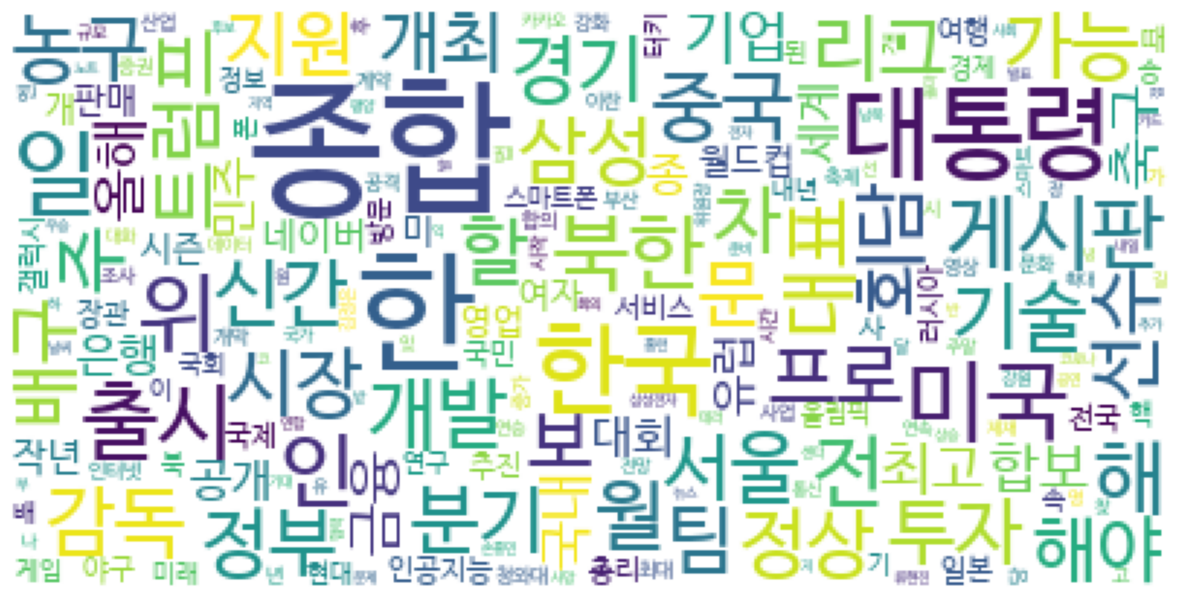

In [17]:
from wordcloud import WordCloud
from collections import Counter

counts = Counter(morph)
tags = counts.most_common(200)

wc = WordCloud(font_path=font_path, background_color="white", max_font_size=50)
cloud = wc.generate_from_frequencies(dict(tags))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(cloud)
plt.show()

이전 wordcloud에 비해서 훨씬 유의미한 토큰만 남은 것을 알 수 있다.